# Exploring BERT with Pre-Training and Transfer Learning

The objective of this report is to compare the performance of a BERT model pre-trainined on the wikitext dataset to the performance of a fully pre-trained BERT model that has been rigorously pre-trained for longer on a much larger dataset.  To judge the performance of the models, I will be testing them on a classification task.  

In the first half of this part of the report, I will be pre-training BERT on the wikitext dataset using the huggingface transformer library.  I will be training 2 models, a large model and a small model.  The large model is identical to the original BERT model.  In particular, the hidden state has dimension 768 and the intermediate state has dimension 3072.  In the small model, the hidden state has dimension 384, and the intermediate state has dimension 1536.  In the second half of this report, I will be using these two models along with a fully pre-trained BERT model from the huggingface library to create a sentence classification model.  This transfer learning will be performed on [this dataset](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/version/1), which contains sentences labeled with one of six different emotions.  The objective of this classifier is to identify the emotion that best describes a sentence. 

First, we begin with pre-processing the wikitext dataset.

## Pre-Training BERT - Pre-Processing

In [20]:
#Importing necessary libraries for entire notebook

!pip install datasets transformers==4.11.2 sentencepiece

from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import csv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertPreTrainedModel, BertModel

from transformers import AutoConfig, AutoTokenizer

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [21]:
# Downloading small wikitext dataset using load_dataset from huggingface transformer library
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

Reusing dataset wikitext (/root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


In [22]:
# Splitting the dataset into 90% train and 10% tets
d = dataset.train_test_split(test_size=0.1)

In [23]:
def dataset_to_text(dataset, filename):
    """For dataset and filename, saves dataset to text file"""
        with open(filename, "w") as f:
            for t in dataset["text"]:
                print(t, file=f)

# save the training set to train.txt
dataset_to_text(d["train"], "train.txt")
# save the testing set to test.txt
dataset_to_text(d["test"], "test.txt")

In [24]:

#These are padding, unknown, masking, etc. tokens
special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
]

# training the tokenizer on the training set
files = ["train.txt"]

# This is the original BERT's vocab size
vocab_size = 30522
# This is the original BERT's max sentence length
max_length = 512
# whether to truncate
truncate_longer_samples = True

In [25]:
# initialize the WordPiece tokenizer from huggingface
tokenizer = BertWordPieceTokenizer()
# train the tokenizer
tokenizer.train(files='train.txt', vocab_size=vocab_size, special_tokens=special_tokens)
# enable truncation up to the maximum 512 tokens
tokenizer.enable_truncation(max_length=max_length)

In [26]:
#This is where we save all the checkpoints and results
model_path = "pretrained-bert"
# make the directory if not already there
if not os.path.isdir(model_path):
    os.mkdir(model_path)

In [27]:
#Saving the trained tokenizer
tokenizer.save_model(model_path)

['pretrained-bert/vocab.txt']

In [28]:
#Saving tokenization parameters and special tokens in model config file
with open(os.path.join(model_path, "config.json"), "w") as f:
    tokenizer_cfg = {
      "do_lower_case": True,
      "unk_token": "[UNK]",
      "sep_token": "[SEP]",
      "pad_token": "[PAD]",
      "cls_token": "[CLS]",
      "mask_token": "[MASK]",
      "model_max_length": max_length,
      "max_len": max_length,
    }
    json.dump(tokenizer_cfg, f)

In [29]:
# Loading tokenizer using BertTokenizerFast from huggingface transformer library
tokenizer = BertTokenizerFast.from_pretrained(model_path)

Didn't find file pretrained-bert/tokenizer.json. We won't load it.
Didn't find file pretrained-bert/added_tokens.json. We won't load it.
Didn't find file pretrained-bert/special_tokens_map.json. We won't load it.
Didn't find file pretrained-bert/tokenizer_config.json. We won't load it.
loading file pretrained-bert/vocab.txt
loading file None
loading file None
loading file None
loading file None
loading configuration file pretrained-bert/config.json
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 512,
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_

In [30]:
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True)

def encode_without_truncation(examples):
    """Mapping function to tokenize the sentences passed without truncation"""
    return tokenizer(examples["text"], return_special_tokens_mask=True)

# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation

# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as 
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
train_dataset, test_dataset

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

(Dataset({
     features: ['text', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
     num_rows: 33046
 }), Dataset({
     features: ['text', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
     num_rows: 3672
 }))

In [31]:
# Main data processing function that will concatenate all texts from our dataset and generate chunks of
# max_seq_length.
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder
    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # Split by chunks of max_len
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

if not truncate_longer_samples:
    train_dataset = train_dataset.map(group_texts, batched=True, batch_size=2_000,
                                    desc=f"Grouping texts in chunks of {max_length}")
    test_dataset = test_dataset.map(group_texts, batched=True, batch_size=2_000,
                                  num_proc=4, desc=f"Grouping texts in chunks of {max_length}")

In [32]:
# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.2
)

## Pre-Training BERT - Pre-Training

Now, it is time to perform the pre-training.  I will be pre-training a small and large model.  In the large model, the hidden state has dimension 768 and the intermediate state has dimension 3072.  In the small model, the hidden state has dimension 384, and the intermediate state has dimension 1536.

In [33]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,      
    num_train_epochs=5,            # number of training epochs
    per_device_train_batch_size=10, # the training batch size
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=32,  # evaluation batch size
    logging_steps=50,             
    save_steps=100,
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# initialize the small model
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length, hidden_size=384, intermediate_size=1536)
model = BertForMaskedLM(config=model_config)

In [ ]:
# initialize the trainer for the large model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
#Train Small Model

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask.
***** Running training *****
  Num examples = 33046
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 8
  Total optimization steps = 2065


Step,Training Loss,Validation Loss
50,9.409900,8.869077
100,8.471500,8.099809
150,7.796700,7.569655
200,7.375600,7.243011
250,7.140400,7.104981
300,7.031000,7.041823
350,6.997200,7.005230
400,6.948100,6.971970
450,6.941100,6.937401
500,6.905900,6.929474


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
Saving model checkpoint to pretrained-bert/checkpoint-100
Configuration saved in pretrained-bert/checkpoint-100/config.json
Model weights saved in pretrained-bert/checkpoint-100/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` a

TrainOutput(global_step=2065, training_loss=6.936111099206218, metrics={'train_runtime': 7159.8546, 'train_samples_per_second': 23.077, 'train_steps_per_second': 0.288, 'total_flos': 1.0899246939291648e+16, 'train_loss': 6.936111099206218, 'epoch': 5.0})

In [17]:
# initialize the large model
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length, hidden_size=768, intermediate_size=3072)
model = BertForMaskedLM(config=model_config)

In [18]:
# initialize the trainer for the large model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [19]:
#Train large model

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: special_tokens_mask, text.
***** Running training *****
  Num examples = 33046
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 8
  Total optimization steps = 2065


Step,Training Loss,Validation Loss
50,8.555900,7.802297
100,7.437700,7.232141
150,7.093300,7.063266
200,6.960900,6.956327
250,6.887000,6.894192
300,6.921800,6.856801
350,6.865700,6.829479
400,6.849300,6.804782
450,6.799600,6.806821
500,6.745700,6.754200


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: special_tokens_mask, text.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: special_tokens_mask, text.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
Saving model checkpoint to pretrained-bert/checkpoint-100
Configuration saved in pretrained-bert/checkpoint-100/config.json
Model weights saved in pretrained-bert/checkpoint-100/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: special_tokens_mask, text.
***** Running Evaluation *****
  Num examples = 3672
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` a

TrainOutput(global_step=2065, training_loss=6.6982208288899345, metrics={'train_runtime': 14339.7289, 'train_samples_per_second': 11.523, 'train_steps_per_second': 0.144, 'total_flos': 4.34877519900672e+16, 'train_loss': 6.6982208288899345, 'epoch': 5.0})

In [36]:
def read_json(file_name):
    """
    Given file_name of json training log, returns train and val
    losses as lists
    """
    f = open(file_name)
    data = json.load(f)
    train_loss = []
    val_loss = []
    for i in data['log_history']:
        try:
            train_loss.append(i['loss'])
        except KeyError:
            pass
        try:
            val_loss.append(i['eval_loss'])
        except KeyError:
              pass
    return train_loss, val_loss

In [43]:
#Getting the train and val losses

small_train_loss, small_val_loss = read_json('/content/trainer_state_small.json')
large_train_loss, large_val_loss = read_json('/content/trainer_state_large.json')

#For plotting we need list of iterations in increments of 50
time = [50*i for i in range(1,41)]

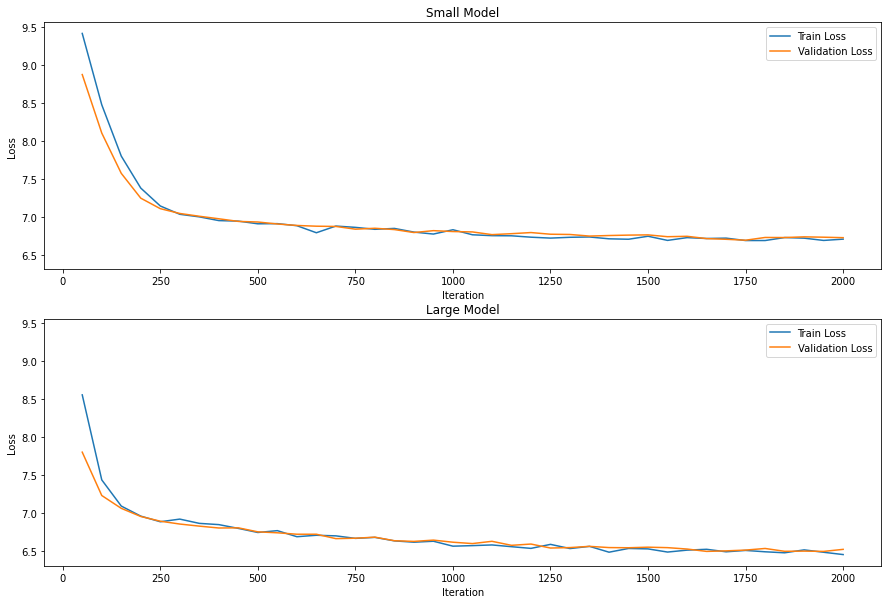

In [47]:
#Plotting validation and train loss

fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=True)
axs[0].plot(time, small_train_loss, label="Train Loss")
axs[0].plot(time, small_val_loss, label="Validation Loss")
axs[0].set_title('Small Model')
axs[0].legend()
axs[1].plot(time, large_train_loss, label="Train Loss")
axs[1].plot(time, large_val_loss, label="Validation Loss")
axs[1].set_title('Large Model')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Loss')

plt.show()

Above are graphs of the train and validation losses for both the small and large models.  The validation loss for the small model achieved a minimum of 6.69 at iteration 1750.  The validation loss for the large model achieved a minumum at iteration 1950 at 6.50.  The small model began to overfit slightly after iteration 1750, as the validation loss began to subtly increase.  The validation loss of the large model also began to increase slightly after iteration 1950, but it is unclear if this is a sign of the beginning of overfitting, as it is possible that the loss may have decreased a bit more with more training.  However, it appears that by the end of training, the validation loss has mostly bottomed out, so I expected that with more training, the model would soon overfit.  

Since the minimum of the validation loss for the large network is about 0.2 less than the minimum of the validation loss for the small network, it appears that the large network somewhat outperformed the small network.  However, given that this difference is very small, I am hesitant to conclude that one network is better than the other.  Keep in mind that I have pre-trained these networks on a very, very small dataset.  Usually, these networks are trained on datasets that are 50 to 100 times larger (or more) and achieve a validation loss well below the minima of the losses of the networks trained above.  Therefore, compared to fully pre-trained networks, both the small and large models performed equally as poorly.

We will now see whether or not the poor performance on pre-training will have an effect on a classification task.  Since the large model achieved its best performance at iteration 1950 and the small model reached its best performance at iteration 1750, I will be using the weights that were saved at these respective points.

## Transfer Learning - Pre-Processing and Defining Model

In the second half of this report, I will be using the models pretrained above to construct a sentence classifier that classifies sentences as exhibiting one of six emotions (joy, sadness, anger, fear, love, or surprise).  I will compare the performance of these two models to the fully pretrained BERT model available via the huggingface transformer library.  This model was trained for longer on a wikipedia dataset that is about 50 times larger.  So, we will see if the higher quality pretraining will result in superior performance on this classification task.   The dataset that I will use to train the model can be found [here](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/version/1).

Before training the models, first let's look at the data, do some pre-processing, and create the classification model.

In [48]:
#Loading data.  Can be found here:

train_df = pd.read_csv('/content/train.txt', sep=';')
test_df = pd.read_csv('/content/test.txt', sep=';')
val_df = pd.read_csv('/content/val.txt', sep=';')

In [49]:
#Adjusting column names

train_df.columns = ['sentence', 'emotion']
test_df.columns = ['sentence', 'emotion']
val_df.columns = ['sentence', 'emotion']

In [61]:
# get max len and mean len of sentences
def max_len(data):
    return data['sentence'].apply(lambda x: len(x.split())).max()

def mean_len(data):
    return data['sentence'].apply(lambda x: len(x.split())).mean()

In [71]:
max_sent = max([max_len(train_df), max_len(test_df), max_len(val_df)])
print('The maximum sentence length in the dataset is', max_sent)

The maximum sentence length in the dataset is 66


In [72]:
from numpy.lib.function_base import average

mean_sent = average([mean_len(train_df), mean_len(test_df), mean_len(val_df)])
print('The average sentence length in the dataset is', round(mean_sent, 2))

The average sentence length in the dataset is 19.06


In [51]:
train_df.head(x="Car", y="Reg_Price", kind="bar", figsize=(10, 9))

,sentence,emotion
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness


In [60]:
train_df['emotion'].value_counts()

joy         5362
sadness     4665
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

Above are a few important facts about the dataset along with some examples.  The maximum sentence length is 66, but the mean sentence length is 19.  So, most of the sentences are relatively short, but there are some outliers that are very long.  A few examples are shown above along with their labels.  The distribution of the dataset across the six labels is also displayed.  Note that the dataset is far from evenly distributed.  We may need to take this into account when looking at the performance of the networks below.

Now, let's set up the model and tokenizer.



In [73]:
#Defining global variables

MODEL_OUT_DIR = '/content/model'
TRAIN_FILE_PATH = '/content/train.txt'
VALID_FILE_PATH = '/content/val.txt'
TEST_FILE_PATH = '/content/test.txt'
MAX_LEN_TRAIN = max_len(train_df)
MAX_LEN_VALID = max_len(test_df)
MAX_LEN_TEST = max_len(val_df)
BATCH_SIZE = 128
NUM_THREADS = 1  ## Number of threads for collecting dataset
MODEL_NAME = 'bert-base-uncased'
LABEL_DICT = {'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4, 'surprise':5}

if not os.path.isdir(MODEL_OUT_DIR):
    os.makedirs(MODEL_OUT_DIR)

In [74]:
#This class creates the pytorch dataset

class Emotions_Dataset(Dataset):

    def __init__(self, filename, maxlen, tokenizer, label_dict): 
        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = ';')
        # name columns
        self.df.columns = ['sentence', 'emotion']
        #Initialize the tokenizer for the desired transformer model
        self.df['emotion'] = self.df['emotion'].map(label_dict)
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'sentence']
        label = self.df.loc[index, 'emotion']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(sentence) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        label = torch.tensor(label, dtype=torch.long)
        
        return input_ids, attention_mask, label

In [93]:
#This class creates the pytorch classifier

class BertEmotionClassifier(BertPreTrainedModel):
    def __init__(self, config, **kwargs):
        super().__init__(config)
        
        #Define BERT model
        self.bert = BertModel(config)

        #kwargs
        self.OPTIMIZER = kwargs['OPTIMIZER']
        self.CRITERION = kwargs['CRITERION']
        self.LEARNING_RATE = kwargs['LEARNING RATE']
        self.EPOCHS = kwargs['EPOCHS']
        self.DEVICE = kwargs['DEVICE']

        #Saves training/validation history
        self.results = None

        #The classification layer that takes the [CLS] representation and outputs the logit
        self.cls_layer = nn.Linear(config.hidden_size, 6)

    def forward(self, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        reps = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        cls_reps = reps[0][:,0]
        logits = self.cls_layer(cls_reps)
        return logits
      
    def epoch_end(self, epoch, result):
        """
        Prints results of epoch given epoch number and epoch results dictionary
        """
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
      
    def accuracy(self, out, labels):
        """
        Given model output and labels tensors, returns accuracy
        """
        probs = F.softmax(out, dim=1)
        output = torch.argmax(probs, dim=1)
        acc = (output == labels).float().mean()
        return acc
      
    def evaluate(self, dataloader):
        """
        Given dataloader, returns accuracy and loss
        """
        model.eval()
        mean_acc, mean_loss, count = 0, 0, 0
        with torch.no_grad():
            for input_ids, attention_mask, labels in (dataloader):
                
                #Move items to GPU
                input_ids, attention_mask, labels = input_ids.to(self.DEVICE), attention_mask.to(self.DEVICE), labels.to(self.DEVICE)

                #Push through model
                logits = model(input_ids, attention_mask)
                
                mean_loss += self.CRITERION(logits.squeeze(-1), labels).item()
                mean_acc += self.accuracy(logits, labels)
                count += 1
        return mean_acc/count, mean_loss/count
            
    def fit(self, train_iter, val_iter):
        """
        Given training and validation iterator, returns list of dictionaries,
        one for each epoch, containing train and val loss and val accuracy
        """
        history = []
        #Define optimizer and parameters to optimize:
        optimizer = self.OPTIMIZER(self.parameters(), lr=self.LEARNING_RATE)

        for epoch in range(self.EPOCHS):
        # Training Phase 
        self.train()
        train_losses = []
            for i, (input_ids, attention_mask, labels) in enumerate(iterable=train_iter):

                input_ids, attention_mask, labels = input_ids.to(self.DEVICE), attention_mask.to(self.DEVICE), labels.to(self.DEVICE)

                out = model(input_ids=input_ids, attention_mask=attention_mask)

                loss = self.CRITERION(out, labels)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = {}
            result['train_loss'] = torch.stack(train_losses).mean().item()
            val_acc, val_loss = self.evaluate(val_iter)
            result['val_loss'] = val_loss
            result['val_acc'] = val_acc
            #Print results of epoch:
            self.epoch_end(epoch, result)
            history.append(result)
        self.results = history

    def predict(self, dataloader):
        """
        Given dataloader, returns predictions and labels as lists
        """
        predicted_label = []
        actual_label = []
        with torch.no_grad():
            for input_ids, attention_mask, labels in (dataloader):
              
                input_ids, attention_mask, labels = input_ids.to(self.DEVICE), attention_mask.to(self.DEVICE), labels.to(self.DEVICE)
                logits = model(input_ids, attention_mask)

                probs = F.softmax(logits, dim=1)
                output = torch.argmax(probs, dim=1)

                predicted_label += output.tolist()
                actual_label += labels.tolist()
              
        return predicted_label, actual_label

    def test(self, dataloader):
        """
        Given dataloader, returns test results including
        confusion matrix, f1, precision, recall, and accuracy
        """
        preds, labels = self.predict(dataloader)
        cm = confusion_matrix(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        prec = precision_score(labels, preds, average='macro')
        rec = recall_score(labels, preds, average='macro')
        acc = (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4]+cm[5,5])/np.sum(cm)
        return cm, f1, prec, rec, acc

    def save_results(self, file_name):
        """
        Saves train/val loss and val accuracy history as csv
        file_name = '<file_name>.csv'
        """
        keys = self.results[0].keys()
        with open(file_name, 'w', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows(self.results)

    def save_model(self, file_name):
        """
        Saves weight dict of model
        file_name = '<file_name>.pt'
        """
        torch.save(self.state_dict(), file_name)


In [94]:
## Tokenizer loaded from AutoTokenizer.  We can use the same one for all 3 models
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## Training Dataset
train_set = Emotions_Dataset(filename=TRAIN_FILE_PATH, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer, label_dict=LABEL_DICT)
valid_set = Emotions_Dataset(filename=VALID_FILE_PATH, maxlen=MAX_LEN_VALID, tokenizer=tokenizer, label_dict=LABEL_DICT)
test_set = Emotions_Dataset(filename=TEST_FILE_PATH, maxlen=MAX_LEN_TEST, tokenizer=tokenizer, label_dict=LABEL_DICT)


## Data Loaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)



loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/

## Transfer Learning - Training Models

Now, we are ready to train and test the three networks.  Experimentation revealed that each of the three networks needs a different number of epochs for training.  Therefore, I will be training the fully pre-trained network for 7 epochs, the large network for 15, and the small network for 20.

In [95]:
#Defining device

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [116]:
#These are general parameters needed for each model

#Fully-Pretrained
params1 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.CrossEntropyLoss(),
          'LEARNING RATE': 1e-5,
          'EPOCHS': 7,
          'DEVICE': DEVICE}

#Small
params2 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.CrossEntropyLoss(),
          'LEARNING RATE': 1e-5,
          'EPOCHS': 20,
          'DEVICE': DEVICE}

#Large
params2 = {'OPTIMIZER': optim.Adam,
          'CRITERION': nn.CrossEntropyLoss(),
          'LEARNING RATE': 1e-5,
          'EPOCHS': 15,
          'DEVICE': DEVICE}

In [97]:
#This df holds the test results for all models

df_test_results = pd.DataFrame({'Model': [],
                    'Accuracy': [],
                    'Precision Score': [],
                    'Recall Score': [],
                    'F1 Score': [],
                    'Confusion Matrix': []})

In [98]:
## Configuration loaded from AutoConfig - MODEL_NAME refers to model held at huggingface Github 
config = AutoConfig.from_pretrained(MODEL_NAME)
## Loading fully pretrained config and model
model = BertEmotionClassifier.from_pretrained(MODEL_NAME, config=config, **params1)
## Putting model to device
model = model.to(DEVICE)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache 

In [99]:
#Training fully pretrained model

model.fit(train_loader, valid_loader)

Epoch [0], train_loss: 1.0467, val_loss: 0.4826, val_acc: 0.8358
Epoch [1], train_loss: 0.3173, val_loss: 0.2157, val_acc: 0.9171
Epoch [2], train_loss: 0.1679, val_loss: 0.1828, val_acc: 0.9231
Epoch [3], train_loss: 0.1263, val_loss: 0.1701, val_acc: 0.9302
Epoch [4], train_loss: 0.1042, val_loss: 0.1794, val_acc: 0.9328
Epoch [5], train_loss: 0.0906, val_loss: 0.1833, val_acc: 0.9339
Epoch [6], train_loss: 0.0818, val_loss: 0.1746, val_acc: 0.9320


In [100]:
#Saving model and history

model.save_results('results_reg.csv')
model.save_model('model_reg.pt')

In [101]:
#Testing fully pretrained model

cm, f1, prec, rec, acc = model.test(test_loader)
df_test_results.loc[len(df_test_results.index)] = ['Fully Pretrained Model', acc, prec, rec, f1, cm]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [108]:
## Configuration loaded from AutoConfig using config created for small model
config = AutoConfig.from_pretrained('/content/small-model')
## Creating the model from small model config and weights
model = BertEmotionClassifier.from_pretrained('/content/small-model', config=config, **params2)
## Putting model to device
model = model.to(DEVICE)


loading configuration file /content/small-model/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.11.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/small-model/pytorch_model.bin
Some weights of the model checkpoint at /content/small-model were not used when initializing BertEmotionClassifier: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.

In [109]:
#Training small model

model.fit(train_loader, valid_loader)

Epoch [0], train_loss: 1.5811, val_loss: 1.5679, val_acc: 0.3686
Epoch [1], train_loss: 1.5460, val_loss: 1.5102, val_acc: 0.4210
Epoch [2], train_loss: 1.4043, val_loss: 1.2421, val_acc: 0.5464
Epoch [3], train_loss: 1.1340, val_loss: 0.9331, val_acc: 0.6601
Epoch [4], train_loss: 0.8063, val_loss: 0.6108, val_acc: 0.7942
Epoch [5], train_loss: 0.5365, val_loss: 0.4259, val_acc: 0.8559
Epoch [6], train_loss: 0.4065, val_loss: 0.3828, val_acc: 0.8611
Epoch [7], train_loss: 0.3305, val_loss: 0.3565, val_acc: 0.8759
Epoch [8], train_loss: 0.2881, val_loss: 0.3111, val_acc: 0.8851
Epoch [9], train_loss: 0.2599, val_loss: 0.2974, val_acc: 0.8877
Epoch [10], train_loss: 0.2278, val_loss: 0.2939, val_acc: 0.8909
Epoch [11], train_loss: 0.2112, val_loss: 0.2990, val_acc: 0.8905
Epoch [12], train_loss: 0.1856, val_loss: 0.2742, val_acc: 0.8985
Epoch [13], train_loss: 0.1753, val_loss: 0.2793, val_acc: 0.8970
Epoch [14], train_loss: 0.1655, val_loss: 0.2812, val_acc: 0.8986
Epoch [15], train_lo

In [110]:
#Saving small model and history

model.save_results('results_small.csv')
model.save_model('model_small.pt')

In [112]:
#Testing small model

cm, f1, prec, rec, acc = model.test(test_loader)
df_test_results.loc[len(df_test_results.index)] = ['Small Model', acc, prec, rec, f1, cm]

In [117]:
## Configuration loaded from AutoConfig using config created for large model
config = AutoConfig.from_pretrained('/content/large-model/')
## Creating the model from small model config and weights
model = BertEmotionClassifier.from_pretrained('/content/large-model/', config=config, **params2)
## Putting model to device
model = model.to(DEVICE)


loading configuration file /content/large-model/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.11.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/large-model/pytorch_model.bin
Some weights of the model checkpoint at /content/large-model/ were not used when initializing BertEmotionClassifier: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform

In [118]:
#Training large model

model.fit(train_loader, valid_loader)

Epoch [0], train_loss: 1.5802, val_loss: 1.5384, val_acc: 0.4133
Epoch [1], train_loss: 1.3883, val_loss: 1.1439, val_acc: 0.5795
Epoch [2], train_loss: 0.9966, val_loss: 0.6987, val_acc: 0.7681
Epoch [3], train_loss: 0.5374, val_loss: 0.4472, val_acc: 0.8520
Epoch [4], train_loss: 0.3349, val_loss: 0.3241, val_acc: 0.8794
Epoch [5], train_loss: 0.2390, val_loss: 0.3013, val_acc: 0.8882
Epoch [6], train_loss: 0.1949, val_loss: 0.2869, val_acc: 0.8894
Epoch [7], train_loss: 0.1725, val_loss: 0.2886, val_acc: 0.8992
Epoch [8], train_loss: 0.1601, val_loss: 0.2974, val_acc: 0.8966
Epoch [9], train_loss: 0.1474, val_loss: 0.2908, val_acc: 0.8980
Epoch [10], train_loss: 0.1288, val_loss: 0.2923, val_acc: 0.8984
Epoch [11], train_loss: 0.1133, val_loss: 0.2979, val_acc: 0.9010
Epoch [12], train_loss: 0.0983, val_loss: 0.3136, val_acc: 0.8972
Epoch [13], train_loss: 0.0975, val_loss: 0.3381, val_acc: 0.8918
Epoch [14], train_loss: 0.0833, val_loss: 0.3340, val_acc: 0.8949


In [119]:
#Saving large model and history

model.save_results('results_large.csv')
model.save_model('model_large.pt')

In [120]:
#Testing large model

cm, f1, prec, rec, acc = model.test(test_loader)
df_test_results.loc[len(df_test_results.index)] = ['Large Model', acc, prec, rec, f1, cm]

In [122]:
#Saving test results

df_test_results.to_pickle('test_results.pkl')

## Transfer Learning - Results

In [123]:
#Loading train/val histories

df1 = pd.read_csv("/content/results_reg.csv")
df2 = pd.read_csv("/content/results_small.csv")
df3 = pd.read_csv("/content/results_large.csv")

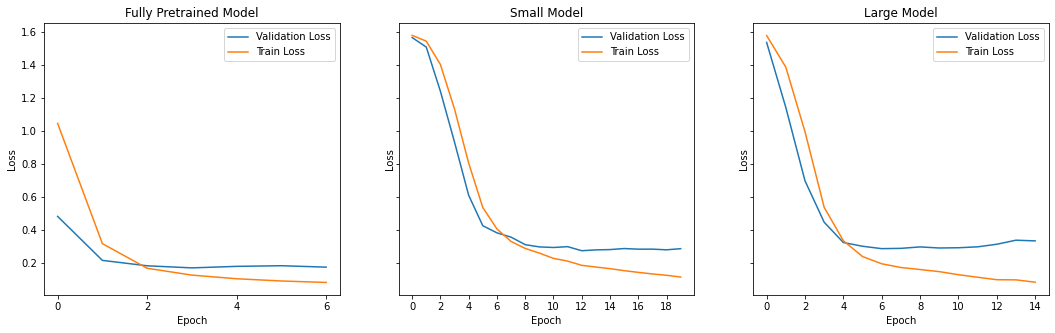

In [156]:
#Plotting validation and train loss

fig, axs = plt.subplots(1, 3, figsize=(18,5), sharey=True)
axs[0].plot(range(7), df1['val_loss'], label="Validation Loss")
axs[0].plot(df1['train_loss'], label="Train Loss")
axs[0].set_title('Fully Pretrained Model')
axs[0].set_xticks([0,2,4,6])
axs[0].legend()
axs[1].plot(range(20), df2['val_loss'], label="Validation Loss")
axs[1].plot(df2['train_loss'], label="Train Loss")
axs[1].set_title('Small Model')
axs[1].set_xticks([0,2,4,6,8,10,12,14,16,18])
axs[1].legend()
axs[2].plot(range(15), df3['val_loss'], label="Validation Loss")
axs[2].plot(df3['train_loss'], label="Train Loss")
axs[2].set_title('Large Model')
axs[2].set_xticks([0,2,4,6,8,10,12,14])
axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

plt.show()

Above are graphs of the training and validation losses for the three models.  As noted above, each network was trained for a different number of epochs.  Training beyond these points would result in overfitting and would hurt the performances of the models.  It is interesting to note that the fully pre-trained model converged very quickly.  It needed only 7 epochs total, and the validation loss began to level out already by the third epoch.  This is in contrast to the small model, which required 20 epochs, and the large model, which required 15 epochs.

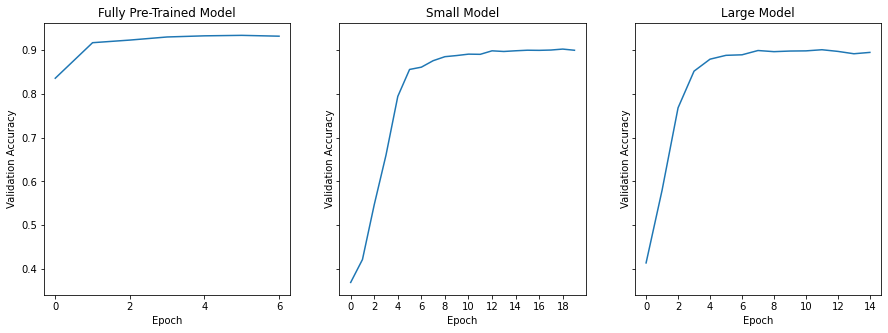

In [159]:
#Plotting validation accuracies

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
axs[0].plot(range(7), [float(df1['val_acc'][i][7:13]) for i in range(len(df1['val_acc']))], label="Fully Pre-trained")
axs[0].set_title('Fully Pre-Trained Model')
axs[0].set_xticks([0,2,4,6])
axs[1].plot(range(20), [float(df2['val_acc'][i][7:13]) for i in range(len(df2['val_acc']))], label="Small Model")
axs[1].set_title('Small Model')
axs[1].set_xticks([0,2,4,6,8,10,12,14,16,18])
axs[2].plot(range(15), [float(df3['val_acc'][i][7:13]) for i in range(len(df3['val_acc']))], label="Large Model")
axs[2].set_title('Large Model')
axs[2].set_xticks([0,2,4,6,8,10,12,14])

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Validation Accuracy')

plt.show()

Above are the graphs of the validation accuracies for each model.  They exhibit behavior similar to their counterparts in the previous figure.  The fully pre-trained model plateaued at about 0.93, while the other two networks achieved accuracies of about 0.9.

In [183]:
#Loading test results

df_test_results = pd.read_pickle('test_results.pkl')

In [184]:
#Function for normalizing the confusion matrices (needed since the distribution
#of labels is skewed)

def normalize_cm(cm):
    norm_cm = np.zeros((6,6))
    counts = test_df['emotion'].value_counts()
        for i in range(6):
            for j in range(6):
                norm_cm[i,j] = cm[i,j]/counts[i]
    return norm_cm


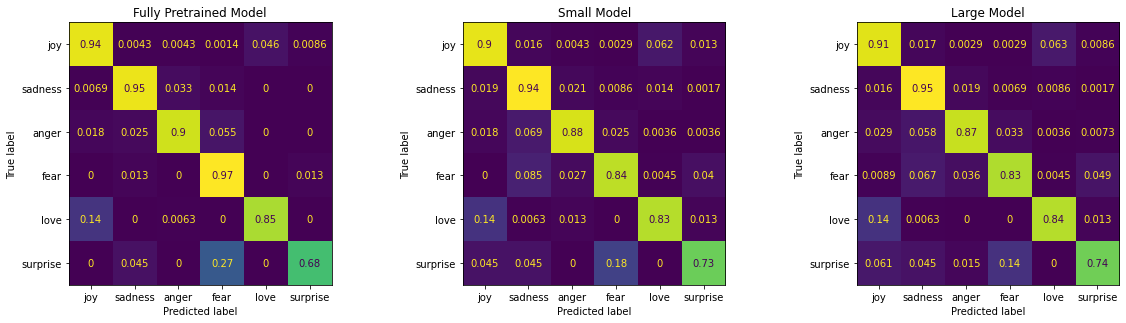

In [186]:
#Plotting confusion matrices

fig, axes = plt.subplots(1, 3, figsize=(20,15))

for ax, i in zip(axes.flat, range(3)):
    cm = normalize_cm(df_test_results['Confusion Matrix'][i])
    disp = ConfusionMatrixDisplay(cm, display_labels=LABEL_DICT)
    disp.plot(ax=ax)
    ax.set_title(df_test_results['Model'][i])
    disp.im_.colorbar.remove()

plt.show()

Above are the confusion matrices for each of the models.  It is interesting to see that all three models had confusion between joy and love as well as between fear and surprise.  Also, it is surprising that the fully pre-trained model did more poorly on the 'surprise' examples than the other two models, despite performing better overall.  In particular, its accuracy for the label is only 0.68.  Recall that the dataset had very few examples for the 'surprise' label.  Perhaps this lack of data compared to the other categories explains why all the networks perform poorly with this label.

In [151]:
#Displaying test results

df_test_results.loc[:, :'F1 Score']

,Model,Accuracy,Precision Score,Recall Score,F1 Score
0,Fully Pretrained Model,0.922961,0.886678,0.881285,0.881751
1,Small Model,0.890945,0.840200,0.853263,0.845695
2,Large Model,0.894447,0.845156,0.857069,0.849910


Above is a table containing the accuracy, precision, recall, and F1 scores for each network.  As expected, the fully pre-trained model had the best scores across the board.  But, surprisingly, the small and large models were not far behind, with the large model performing slightly better than the small model.  The F1 scores for all the networks are fairly high, which reflects the fact that most of the entries in the confusion matrices above are nearly zero.  Therefore, overall, all three networks performed very well.

## Discussion and Conclusion

In the first half of this report, I pre-trained a small and large BERT network on the small wikitext dataset.  Comparing the validation loss of the two networks at the end of training revealed that both networks pre-trained poorly, with the large network doing slightly better than the small one.  Therefore, I was surprised to see how well these two networks competed against a properly pre-trained BERT network on the emotion classification task.  Both networks were less than 3 accuracy points behind the fully pre-trained model.  It seems that the small and large networks were able to 'catch-up' significantly during the transfer learning.  This is reflected in the graphs of the losses and validation accuracies, where we can see that, while it takes longer for the two networks to train, both ultimately achieve an accuracy just below the properly pre-trained network.  Therefore, this experiment has shown yet another powerful property of transfer learning.  It seems that even if the underlying network is not perfectly pre-trained, the transfer learning process may be able to make up the difference.  

However, it may be that the simplicity of the transfer learning task may have made it easier to close the gap between the fully pre-trained model and the other two.  Perhaps a more sophisticated downstream task may not be as successful.
Resources useful for making this notebook:

Pre-Training - https://www.thepythoncode.com/article/pretraining-bert-huggingface-transformers-in-python

Emotion Classification - https://www.kaggle.com/dillonwall/bert-for-sentence-classification-93/notebook